In [11]:
import numpy as np

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_aer.primitives import Sampler
from qiskit_aer.backends import AerSimulator
from qiskit.circuit.library import TwoLocal
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options
from qiskit import transpile, QuantumCircuit

from qiskit_optimization.translators import to_docplex_mp
from docplex.mp.model import Model
from docplex.mp.model_reader import ModelReader
from qiskit_optimization.translators import from_docplex_mp
import time, pickle
from collections import defaultdict

import gibbs_optimizer_v2 as opt

In [2]:
def objective(x):
    objval = x @ J_r @ x
    return objval

In [ ]:
def solve_QP(Q, pprint=False):
    """
    CPLEX solver: Uses adjacency matrix
    """
    
    mdl = Model()
    m,n = Q.shape
    x = mdl.binary_var_list([i for i in range(n)],name='x')
    mdl.minimize(mdl.sum(Q[i,j]*x[i]*x[j] for i in range(n) for j in range(m) ))
    sol = mdl.solve()
    if pprint:
        mdl.prettyprint()
    return {'ov': sol.get_objective_value(),'sol':sol.get_values(x)}


file_name = '../../lp_G0_lp_c/seq_162_c.lp'
mod = Model()
mod = ModelReader.read_model(file_name)

#convert linear program to qubo
qp = from_docplex_mp(mod)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
#quboOp, offset = qubo.to_ising()
Q_info = qubo.objective.quadratic.coefficients.copy()
l_diag = qubo.objective.linear
for k in range(qp.get_num_vars()):
    Q_info[k,k] += l_diag[k]

Q = Q_info.tocoo()
Q_data = np.stack([Q.row, Q.col, Q.data], axis=1)
#print(qubo.prettyprint())

h = l_diag.to_array()

#convert couplings to a symmetric matrix
J_up = qubo.objective.quadratic.to_array()
J = J_up + J_up.T 
#print(J)

#find rows with all entries non-negative
row_del = []
for i in range(J.shape[0]):

    if all(k >= 0 for k in np.r_[J[i, 0:i], J[i, i+1:]]):
        row_del.append(i)

#construct reduced problem
row_keep = list(set(range(0, J.shape[0])) - set(row_del))
J_r = np.delete(np.delete(J, row_del, axis=0), row_del, axis=1)
J_r = np.triu(J_r) #make it up trian
i = 0
for k in row_keep:
    J_r[i, i] += l_diag[k]
    i+=1
print(J_r.shape)

scaling = np.abs(np.max(J_r))
J_r/= scaling

num_qubits = J_r.shape[0]
print(f'number of system qubits: {num_qubits}')

reps = 2

ansatz = TwoLocal(
    num_qubits = num_qubits,
    rotation_blocks = 'ry', 
    entanglement_blocks = 'cz',
    entanglement = 'pairwise', 
    reps = reps,
    insert_barriers = True
    )

n_params = ansatz.num_parameters
print(f'number of params: {n_params}')

shots = 2**15

from qiskit_aer.primitives import Sampler
sampler = Sampler(backend_options={'method' : 'matrix_product_state', 'n_qubits': num_qubits})
sampler.set_options(shots=shots)

QuantumOptimizer = opt.Quantum_Optimizer()
QuantumOptimizer.set_optimizer(num_qubits, ansatz, sampler)
#theta_initial = np.hstack([np.full(num_qubits, np.pi/2), np.zeros(num_qubits*ansatz.reps)])

filename = 'benchmark/N100/N100_' + 'theta' + '.pkl'
with open(filename, 'rb') as fp:
    phi = pickle.load(fp)

x = np.array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
   0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
   1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

restart_s = 0.8
w = x * restart_s * np.pi

theta_initial = np.hstack((w, phi))

time0 = time.time()
prob_list = defaultdict(list)
log = defaultdict(list)

for itrial in range(0, 1):
    theta = theta_initial
    for beta in [0.1]:
        st = time.time()
        opt_run = QuantumOptimizer.run(
        objective = objective, 
        qc_params_init = theta,
        scaling = scaling,
        max_epoch = 2,  
        intermediate_result_display = True,
        refval = None,
        alpha = 1.0, #cVAR param
        beta = beta,
    )
    theta = opt_run['theta']
    filename = 'log_b_' + str(beta) + '_trial_' + str(itrial)
    with open('reduced/' + filename, 'wb') as fp:
        pickle.dump(opt_run, fp)
    
    print(time.time() - st)

gs = opt_run.x 
print(time.time() - time0)

#reconstruct solution
full_sol = np.zeros(J.shape[0])

j = 0
on_idx = []
for i in range(0, J.shape[0]):
    if i in row_keep:
        full_sol[i] = int(gs[j])
        if gs[j] == 1.0:
            on_idx.append(i)
        j+=1

#########################
#### solve smaller qubo for the removed bits
#########################

#collect potential deleted bits
pot_bits = []
for idx in row_del:
    obj = 0.0
    for elem in on_idx:
        obj+=J[idx, elem]

    if obj == 0.0:
        if h[idx] < 0.0: 
            pot_bits.append(idx)

#assumption: length of pot_bits is small
#create a sub-problem
J_pot_bit = np.zeros((len(pot_bits), len(pot_bits)))

m = 0
n = 0
for i in pot_bits:
    for j in pot_bits:
        if i < j:
            J_pot_bit[m, n] = J[i, j]
            n+=1
    m+=1

m = 0
for i in pot_bits:
    J_pot_bit[m, m]+= h[i]
    m+=1

#solve by enumerating
all_possible = [[int(x) for x in i] for i in itertools.product('01', repeat=len(pot_bits))]

best_x = None
best_val = 1e100
for elem in all_possible:
    obj_val = elem @ J_pot_bit @ elem
    if obj_val < best_val:
        best_val = obj_val
        best_x = elem    

#get final solution 
for bit_val, idx in zip(best_x, pot_bits):
    if bit_val == 1:
        full_sol[idx] = 1.0

(109, 109)
number of system qubits: 109
number of params: 327
epoch 0 	 step 0 	 exp_evals 1 	 cvar 0.598 	 fval -555.3699699467396 	 fevals 10 	 best val -127.99999999999999
epoch 0 	 step 1 	 exp_evals 4 	 cvar 1.818 	 fval -1009.8992349372126 	 fevals 63 	 best val -127.99999999999999
epoch 0 	 step 2 	 exp_evals 7 	 cvar 1.834 	 fval -943.486807860697 	 fevals 138 	 best val -127.99999999999999
epoch 0 	 step 3 	 exp_evals 10 	 cvar 2.587 	 fval -1940.1397464783176 	 fevals 217 	 best val -127.99999999999999
epoch 0 	 step 4 	 exp_evals 13 	 cvar 1.798 	 fval -1946.6129944186296 	 fevals 319 	 best val -127.99999999999999
epoch 0 	 step 5 	 exp_evals 16 	 cvar 2.723 	 fval -2040.3872726511177 	 fevals 430 	 best val -127.99999999999999
epoch 0 	 step 6 	 exp_evals 19 	 cvar 2.875 	 fval -2088.566277261044 	 fevals 552 	 best val -127.99999999999999
epoch 0 	 step 7 	 exp_evals 22 	 cvar 3.311 	 fval -1879.213546968975 	 fevals 683 	 best val -127.99999999999999
epoch 0 	 step 8 	 e

In [14]:


reduce_prob(file_name)

(109, 109)
number of system qubits: 109
number of params: 327


NameError: name 'J_r' is not defined

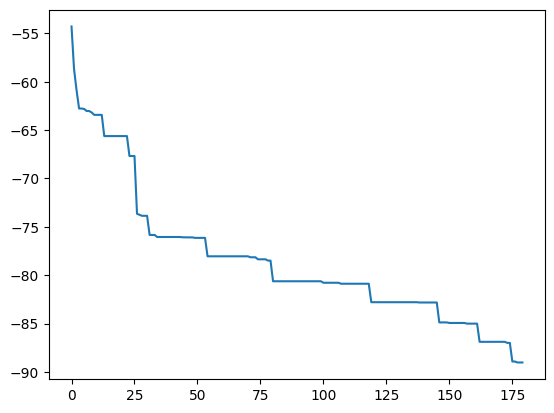

In [36]:
import matplotlib.pyplot as plt

plt.plot(np.mean(all_log, 0))

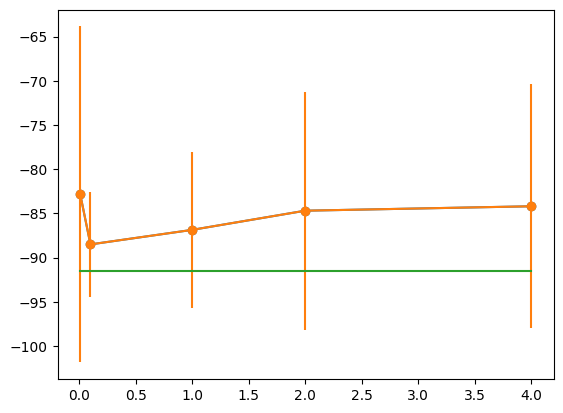

In [101]:
x = [0.01, 0.1, 1.0, 2.0, 4.0]
plt.plot(x, np.mean(list(all_log.values()), axis=0), '-o')
plt.errorbar(x, np.mean(list(all_log.values()), axis=0), 
                                                 np.std(list(all_log.values()), axis=0), marker='o')
plt.plot(x, [-91.5 for i in x], '-')

TypeError: iteration over a 0-d array

In [ ]:
qc = ansatz.bind_parameters(opt_run['theta'])
qc.measure_all()

job = sampler.run(qc)
result = job.result()
quasi_dist = result.quasi_dists[0]
prob_dict = quasi_dist.binary_probabilities()
prob_list[beta].append(prob_dict)  

In [ ]:
from itertools import product
import matplotlib.pyplot as plt

ee = {}
prob = {}

bit_str = [''.join(p) for p in product('10', repeat=num_qubits)]

def energy(x):
    x = np.array(list(x)).astype(int)
    x = np.flip(x) 
    return x @ Q @ x

for beta in np.arange(0.5, 0.6, 0.1):
    Z = 0.0
    for elem in bit_str:
        ee[elem] = objective([int(i) for i in elem])
        prob[elem] = np.exp(-beta * ee[elem])
        Z+= prob[elem]
    
    prob_ee = {k:(v/Z) for (k,v) in zip(ee.values(), prob.values())}
    plt.plot(prob_ee.keys(), prob_ee.values(), 'o')
    plt.plot([energy(x) for x in prob_list[0.5][0].keys()], prob_list[0.5][0].values(), 'o')
    #plt.yscale('log')

In [ ]:
fid = 0.0
for bit_str, val in prob.items():
    if bit_str in prob_list[0.5][0].keys():
        fid+= prob[bit_str] * prob_list[0.5][0][bit_str]
fid

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table

In [99]:
list(all_log.values())

[[-91.5, -89.4, -90.50000000000001, -91.50000000000001, -48.099999999999994],
 [-28.8, -90.50000000000001, -91.5, -90.50000000000001, -89.4],
 [-89.4, -91.5, -90.50000000000001, -91.50000000000001, -91.5],
 [-91.50000000000001,
  -91.50000000000001,
  -91.50000000000001,
  -91.50000000000001,
  -90.50000000000001],
 [-90.50000000000001, -70.9, -70.14999999999999, -91.5, -90.50000000000001],
 [-91.50000000000001, -89.4, -68.5, -50.0, -91.50000000000001],
 [-91.50000000000001,
  -91.50000000000001,
  -91.50000000000001,
  -91.50000000000001,
  -89.4],
 [-91.50000000000001,
  -90.50000000000001,
  -91.5,
  -91.50000000000001,
  -91.50000000000001],
 [-91.5, -90.50000000000001, -91.5, -89.4, -68.05],
 [-70.9, -89.4, -91.5, -68.05, -91.50000000000001]]